In [8]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot config
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def prepare_data(ticker='TSLA', start='2020-01-01', end='2025-11-27'):

    file_path = f"data/{ticker}_data.csv"

    # data loading
    if os.path.exists(file_path):
        print(f"Loading local file {file_path}...")
        df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    else:
        print(f"Downloading {ticker}...")
        df = yf.download(ticker, start=start, end=end)

        # fixing multiinndex before saving to csv to prevent formating errors
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        if not os.path.exists('data'): os.makedirs('data')
        df.to_csv(file_path)

    # if the csv contains "tsla" in a row, convert it to NaN and drop
    df = df.apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    # indicators
    # SMA
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # MACD
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (2 * std_dev)
    df['BB_Lower'] = df['BB_Middle'] - (2 * std_dev)

    # Target (the next day price)
    df['Target'] = df['Close'].shift(-1)

    # cleanup
    df.dropna(inplace=True)

    return df

# Test
df = prepare_data()
print(f"Data ready: {df.shape}")
print(df[['Close', 'SMA_20', 'RSI']].tail())

Loading local file data/TSLA_data.csv...
Data ready: (1435, 14)
                 Close      SMA_20        RSI
Date                                         
2025-11-19  403.989990  436.996002  39.915097
2025-11-20  395.230011  434.308502  32.101801
2025-11-21  391.089996  432.177002  26.390087
2025-11-24  417.779999  430.445001  42.035612
2025-11-25  419.399994  428.387502  35.781409


In [9]:
# check on data structure
print(df.info())
print("\nFirst rows:")
print(df.head())
# print(df.columns)  # useful to remember column names

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1435 entries, 2020-03-13 to 2025-11-25
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        1435 non-null   float64
 1   High         1435 non-null   float64
 2   Low          1435 non-null   float64
 3   Open         1435 non-null   float64
 4   Volume       1435 non-null   int64  
 5   SMA_20       1435 non-null   float64
 6   SMA_50       1435 non-null   float64
 7   RSI          1435 non-null   float64
 8   MACD         1435 non-null   float64
 9   Signal_Line  1435 non-null   float64
 10  BB_Middle    1435 non-null   float64
 11  BB_Upper     1435 non-null   float64
 12  BB_Lower     1435 non-null   float64
 13  Target       1435 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 168.2 KB
None

First rows:
                Close       High        Low       Open     Volume     SMA_20  \
Date                                                

statistics


,count,mean,std,min,25%,50%,75%,max
Close,1435.0,2.401190e+02,8.853391e+01,2.408133e+01,1.877650e+02,2.366633e+02,2.904783e+02,4.798600e+02
High,1435.0,2.455770e+02,9.051382e+01,2.699067e+01,1.914067e+02,2.408800e+02,2.978733e+02,4.885400e+02
Low,1435.0,2.344110e+02,8.655589e+01,2.336733e+01,1.826450e+02,2.321300e+02,2.840883e+02,4.575100e+02
Open,1435.0,2.401867e+02,8.872006e+01,2.498000e+01,1.867150e+02,2.358000e+02,2.910317e+02,4.759000e+02
Volume,1435.0,1.151046e+08,6.351297e+07,2.940180e+07,7.558370e+07,9.862220e+07,1.331926e+08,6.663786e+08
SMA_20,1435.0,2.376733e+02,8.691912e+01,3.257530e+01,1.876075e+02,2.365423e+02,2.900865e+02,4.460515e+02
SMA_50,1435.0,2.335772e+02,8.345513e+01,4.183319e+01,1.841630e+02,2.349753e+02,2.886894e+02,4.337138e+02
RSI,1435.0,5.284848e+01,1.834272e+01,6.919326e+00,4.049959e+01,5.259706e+01,6.519625e+01,9.752993e+01
MACD,1435.0,1.859432e+00,1.128861e+01,-3.558323e+01,-5.274422e+00,2.135137e+00,7.046771e+00,4.053861e+01
Signal_Line,1435.0,1.876662e+00,1.063337e+01,-3.223855e+01,-4.771089e+00,2.075210e+00,7.634063e+00,3.475662e+01


heatmap


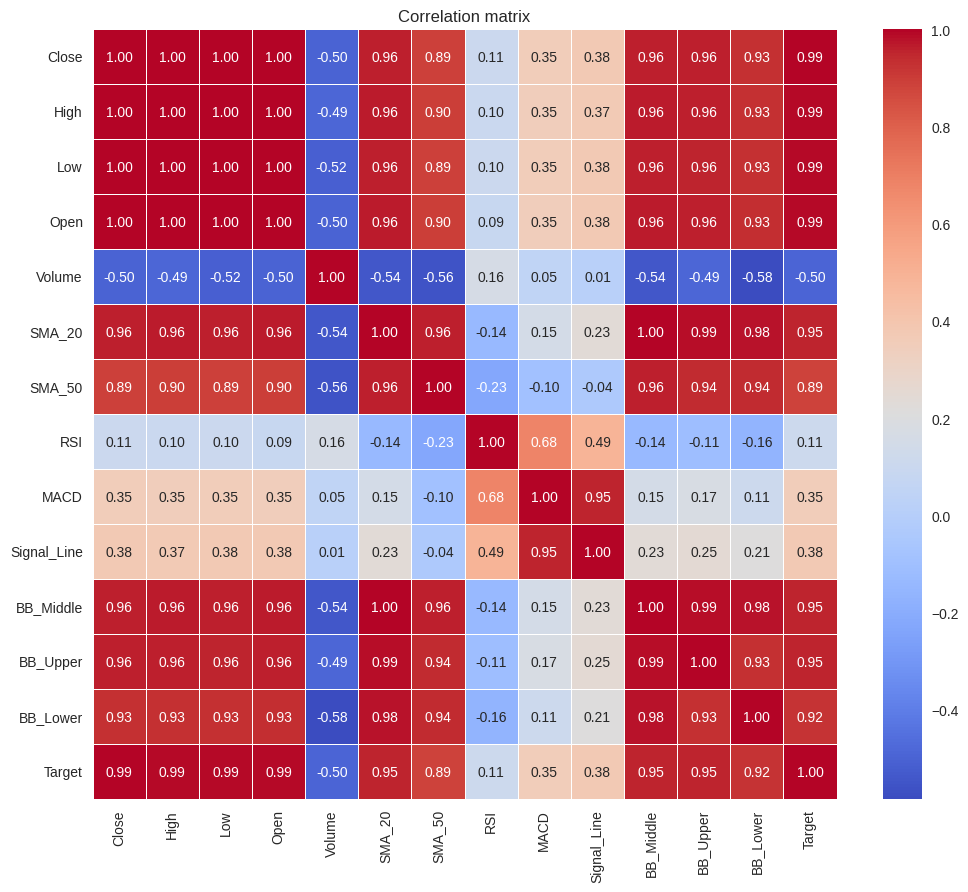

missing values
Close          0
High           0
Low            0
Open           0
Volume         0
SMA_20         0
SMA_50         0
RSI            0
MACD           0
Signal_Line    0
BB_Middle      0
BB_Upper       0
BB_Lower       0
Target         0
dtype: int64


In [10]:
#cell for EDA
import seaborn as sns
import matplotlib.pyplot as plt

print("statistics")
display(df.describe().T)

print("heatmap")
plt.figure(figsize=(12, 10))

# correlation calculations
correlation_matrix = df.corr()

# visualize
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",         # 2 decimals
            linewidths=0.5)

plt.title("Correlation matrix")
plt.show()

# missing values check
print("missing values")
print(df.isnull().sum())

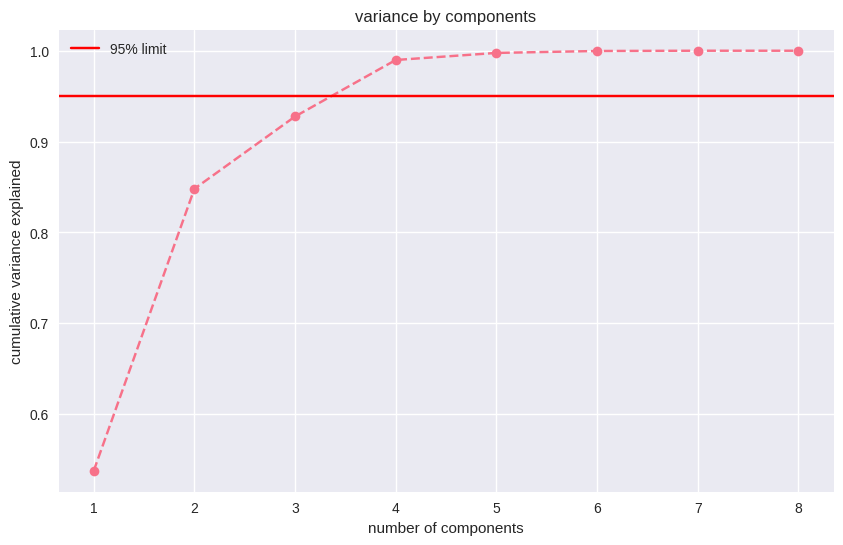

more than 95% of info is held by fewer components
but we will keep original feature for finance interpretability


In [11]:
# PCA
# can we reduce the number of features ?

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# indicators
features_pca = ['Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']
x_raw = df[features_pca]

# scaling
scaler_pca = StandardScaler()
x_scaled = scaler_pca.fit_transform(x_raw)

# pca
pca = PCA()
pca.fit(x_scaled)

# graph variance and pca
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(),
         marker='o', linestyle='--')

plt.title('variance by components')
plt.xlabel('number of components')
plt.ylabel('cumulative variance explained')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% limit')
plt.legend()
plt.grid(True)
plt.show()

# Interpretation
print("more than 95% of info is held by fewer components")
print("but we will keep original feature for finance interpretability")

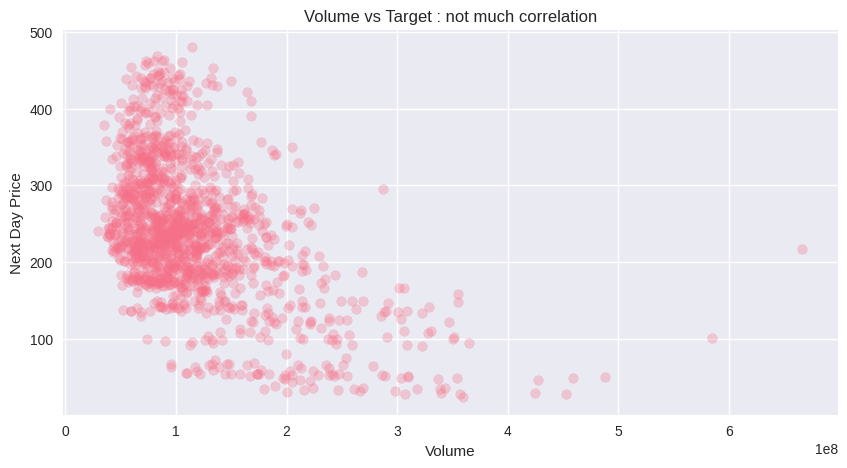

In [12]:
# testing if volume has impact on next day price
plt.figure(figsize=(10,5))
plt.scatter(df['Volume'], df['Target'], alpha=0.3)
plt.xlabel('Volume')
plt.ylabel('Next Day Price')
plt.title('Volume vs Target : not much correlation')
plt.show()

# abandoned this idea, RSI seems more relevant

In [13]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# Baseline vs XGBoost

# Features,Target
features = ['Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI', 'MACD', 'Signal_Line', 'BB_Upper', 'BB_Lower']
X = df[features]
y = df['Target']

# Time Series Split (80/20) no shuffling
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
print(f"Baseline RMSE: {rmse_lr:.2f}")

# XGBoost hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# randomized search because its faster than gridsearch
search = RandomizedSearchCV(xgb, param_dist, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42)
search.fit(X_train, y_train)

# model eval (the best one)
best_xgb = search.best_estimator_
pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"Improvement: {((rmse_lr - rmse_xgb)/rmse_lr)*100:.2f}%")

Baseline RMSE: 13.73
XGBoost RMSE: 33.72
Improvement: -145.51%


In [14]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM model

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])

# sequences (60 days)
LOOKBACK = 60
X_lstm, y_lstm = [], []

for i in range(LOOKBACK, len(scaled_data)):
    X_lstm.append(scaled_data[i-LOOKBACK:i, 0])
    y_lstm.append(scaled_data[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# split (80/20)
split_idx = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

# creation of lstm model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

#training
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm), verbose=0)

#prediction and inverse transform to go back to real prices
predictions = model.predict(X_test_lstm)
pred_lstm = scaler.inverse_transform(predictions)

# RMSE
y_test_real = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
rmse_lstm = np.sqrt(mean_squared_error(y_test_real, pred_lstm))

print(f"LSTM RMSE: {rmse_lstm:.2f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
LSTM RMSE: 25.28


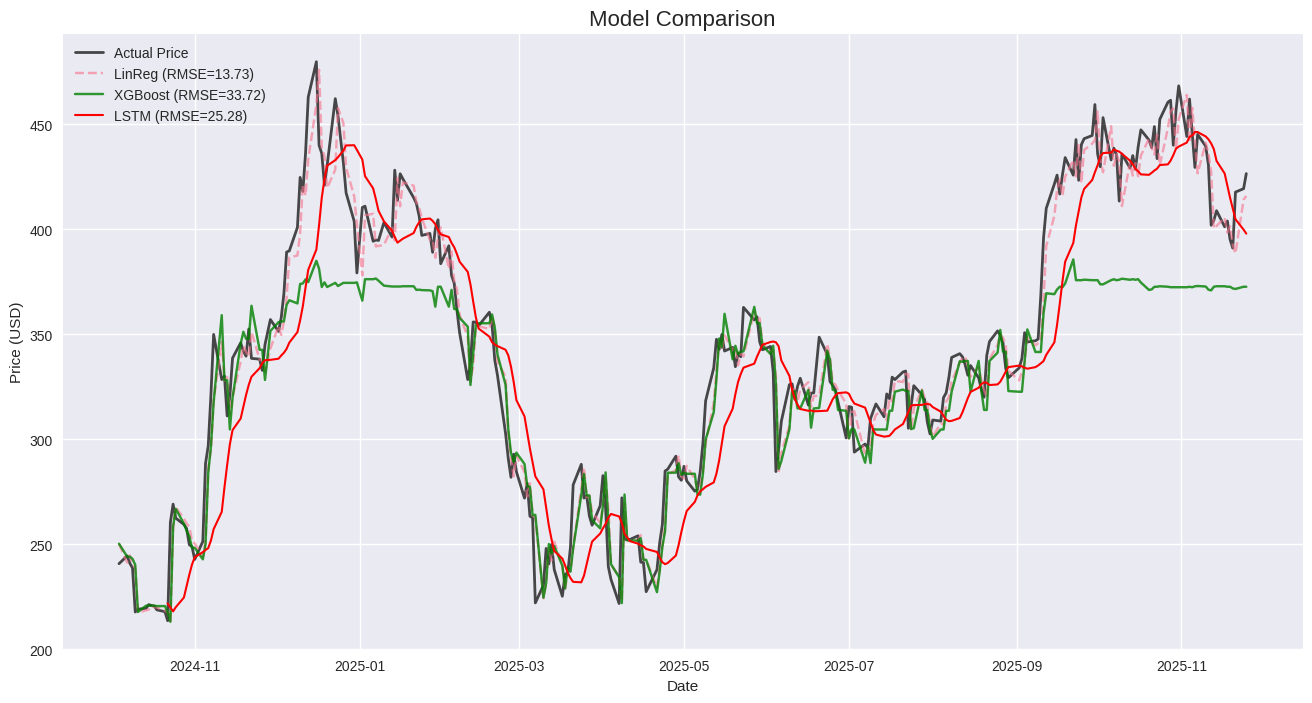

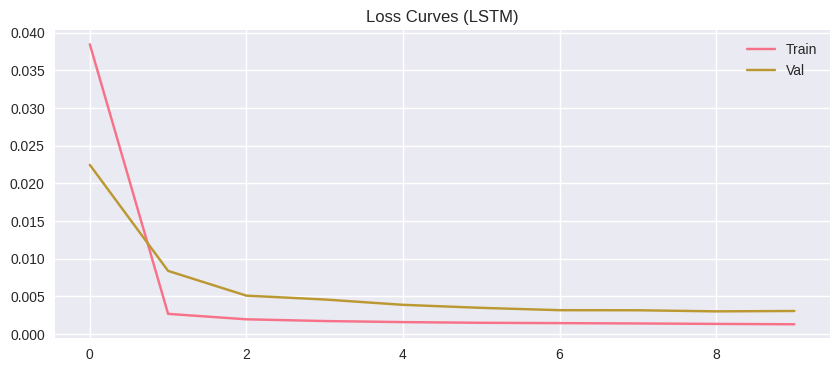

In [15]:
# Visualization

plt.figure(figsize=(16, 8))

dates_test = df.index[-len(y_test):]
dates_lstm = df.index[-len(pred_lstm):]

# curves
plt.plot(dates_test, y_test, label='Actual Price', color='black', linewidth=2, alpha=0.7)
plt.plot(dates_test, pred_lr, label=f'LinReg (RMSE={rmse_lr:.2f})', linestyle='--', alpha=0.6)
plt.plot(dates_test, pred_xgb, label=f'XGBoost (RMSE={rmse_xgb:.2f})', color='green', alpha=0.8)
plt.plot(dates_lstm, pred_lstm, label=f'LSTM (RMSE={rmse_lstm:.2f})', color='red', linewidth=1.5)

plt.title('Model Comparison', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# test for overfitting
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curves (LSTM)')
plt.legend()
plt.show()

RMSE (via Returns): 15.17


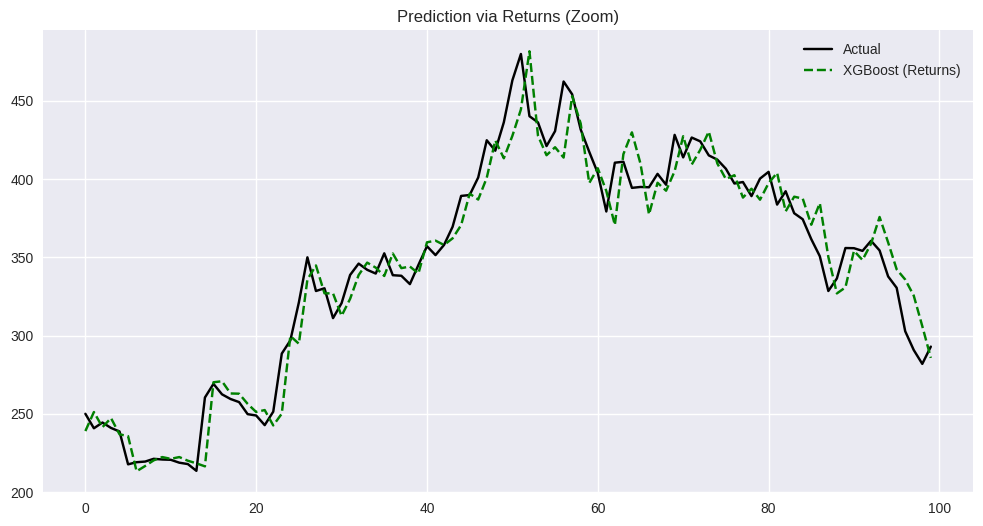

In [16]:
import xgboost as xgb

# bonus method
# trying to predict % change rather than raw price

# returns
df['Return'] = df['Close'].pct_change()
df['Target_Return'] = df['Return'].shift(-1)
df.dropna(inplace=True)

# Features , Split
features_v2 = ['Return', 'Volume', 'RSI', 'MACD', 'Signal_Line']
X = df[features_v2]
y = df['Target_Return']

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Train XGBoost on returns
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)
pred_returns = model_xgb.predict(X_test)

# new price : close_current * (1 + Pred_return)
last_prices = df['Close'].iloc[split:].values
predicted_prices = last_prices * (1 + pred_returns)

# Real future prices (for comparison)
real_target_prices = df['Close'].shift(-1).iloc[split:].dropna().values

# Alignment and RMSE
min_len = min(len(predicted_prices), len(real_target_prices))
rmse_new = np.sqrt(np.mean((real_target_prices[:min_len] - predicted_prices[:min_len])**2))

print(f"RMSE (via Returns): {rmse_new:.2f}")

# Visualization for 100 day
plt.figure(figsize=(12,6))
plt.plot(real_target_prices[:100], label='Actual', color='black')
plt.plot(predicted_prices[:100], label='XGBoost (Returns)', color='green', linestyle='--')
plt.title("Prediction via Returns (Zoom)")
plt.legend()
plt.show()